In [1]:
# PYTHON LIBRARIES
%matplotlib inline

import numpy as np;
import pandas as pd;
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=15)     
plt.rc('ytick', labelsize=15)
import re

from adjustText import adjust_text
from scipy import special, optimize

In [2]:
def get_csv(filename, headDrop, tailDrop):
    df = pd.read_csv(filename, header=None, sep='\n');

    # Remove file header (1st 11 rows)
    r = 11;
    for i in range(r):
        df = df.drop([i]);

    # Split columns by commas
    df = df[0].str.split(",", expand=True);

    new_header = df.iloc[0]; #grab the first row for the header
    df = df[1:]; #take the data less the header row
    df.columns = new_header; #set the header row as the df header

    units = df.iloc[0]; # Get units
    df = df.drop([r+1]); # Remove units row from dataframe
    
    df.drop(df.head(headDrop).index, inplace=True) # drop first headDrop rows
    df.drop(df.tail(tailDrop).index, inplace=True) # drop last tailDrop rows
    '''
    if headDrop > 0:
        for i in range(headDrop):
            df = df.drop([r+2+i]);
            
    if tailDrop > 0:
        for i in range(tailDrop):
            df = df.drop([len(df)]);
    '''

    #      [0]    [1]
    return units, df;

### Cross
### $$ \frac{\eta - b}{a - b} = \frac{1}{1 + (c \dot{\gamma})^d} $$
### $$ \eta = \frac{a - b}{1 + (c \dot{\gamma})^d} + b $$

### where:
$a =$ zero rate viscosity <br>
$b =$ infinite rate viscosity <br>
$c =$ consistency <br>
$d =$ rate index

In [3]:
def Cross_(gamma, eta_zero, eta_inft, kappa, n):
    a = eta_zero;
    b = eta_inft;
    c = kappa;
    d = n;
    
    nume = a - b;
    deno = 1 + (c*gamma)**d;
    
    return (nume/deno) + b;

### Carreau
### $$ \frac{\eta - b}{a - b} = \left[1 + \left(c \dot{\gamma}\right)^2\right]^{\frac{d - 1}{2}} $$
### $$ \eta = \frac{a - b}{\left[1 + \left(c \dot{\gamma}\right)^2\right]^{\frac{1 - d}{2}}} + b $$

### where:
$a =$ zero rate viscosity <br>
$b =$ infinite rate viscosity <br>
$c =$ consistency <br>
$d =$ rate index

In [4]:
def Carreau_(gamma, eta_zero, eta_inft, kappa, n):
    a = eta_zero;
    b = eta_inft;
    c = kappa;
    d = n;
    
    nume = a - b;
    
    base = 1 + (c*gamma)**2;
    expo = (1 - d)/2;
    deno = base**expo;
    
    return (nume/deno) + b;

### The Carreau-Yasuda Model [1]
### $$ \frac{\eta - b}{a - b} = \frac{1}{\left[1 + \left(c \dot{\gamma}\right)^e\right]^{\frac{1 - d}{e}}} $$
### $$ \frac{\eta - \eta_{\infty}}{\eta_0 - \eta_{\infty}} = \frac{1}{\left[1 + \left(\kappa \dot{\gamma}\right)^a\right]^{\frac{(1 - n)}{a}}} $$
### $$ \eta = \frac{\eta_0 - \eta_{\infty}}{\left[1 + \left(\kappa \dot{\gamma}\right)^a\right]^{\frac{(1 - n)}{a}}} + \eta_{\infty} $$

### where:
$\eta =$ Viscosity <br>
$\dot{\gamma} =$ Shear rate <br>
$\eta_{\infty} =$ Infinite shear rate viscosity <br>
$\eta_0 =$ Zero shear rate viscosity <br>
$\kappa =$ Time constant <br>
$n =$ The Power Law index <br>
$a =$ The width of the transition region between the zero shear viscosity and the Power Law region

#### [1] Osswald, T., Rudolph, N., Osswald, T., & Rudolph, N. (2014). Generalized Newtonian Fluid (GNF) Models. Polymer Rheology, 59–99. https://doi.org/10.3139/9781569905234.003

In [5]:
def CarreauYasuda_(gamma, eta_zero, eta_inft, kappa, n, m):
    a = eta_zero;
    b = eta_inft;
    c = kappa;
    d = n;
    e = m;
    
    nume = a - b;
    
    base = 1 + (c*gamma)**e;
    expo = (1 - d)/e;
    deno = base**expo;
    
    return (nume/deno) + b;

### Sisko
### $$ \eta = a + b \dot{\gamma}^{c - 1} $$

### where:
$a =$ infinite rate viscosity <br>
$b =$ consistency <br>
$c =$ rate index

In [6]:
def sisko_(gamma, eta_inft, kappa, n):
    a = eta_inft;
    b = kappa;
    c = n;
    
    expo = c - 1;
    
    return a + b*(gamma**expo);

### Williamson
### $$ \eta = \frac{a}{1 + (b \dot{\gamma})^c} $$

### where:
$a =$ zero rate viscosity <br>
$b =$ consistency <br>
$c =$ rate index

In [7]:
def williamson_(gamma, eta_zero, kappa, n):
    a = eta_zero;
    b = kappa;
    c = n;
    
    deno = 1 + (b*gamma)**c;
    
    return a/deno;

---
### Best Fit

In [8]:
def fit_Model_(filename, headDrop, tailDrop, plotname, modelName, eta_zero=0, eta_inft=0, kappa=0, n=0, m=0):
    # get units and Data
    units_df = get_csv(filename, headDrop, tailDrop)[0]
    nSeal_df = get_csv(filename, headDrop, tailDrop)[1]

    # Chose what to plot
    x_index = 1; # gamma = Shear rate
    y_index = 2; # eta   = Viscosity

    # Optimization process
    gamma = nSeal_df.iloc[:, x_index].to_numpy().astype(np.float);
    eta   = nSeal_df.iloc[:, y_index].to_numpy().astype(np.float);

    # remove neg values
    gamma = gamma[eta >= 0]
    eta = eta[eta >= 0]

    # Optimize according to the selected modelName
    if modelName == 'Cross':
        p0 = eta_zero, eta_inft, kappa, n;
        eta_fit  = Cross_(gamma, eta_zero, eta_inft, kappa, n);
    
    elif modelName == 'Carreau':
        p0 = eta_zero, eta_inft, kappa, n;
        eta_fit  = Carreau_(gamma, eta_zero, eta_inft, kappa, n);
    
    elif modelName == 'CarreauYasuda':
        p0 = eta_zero, eta_inft, kappa, n, m;
        eta_fit  = CarreauYasuda_(gamma, eta_zero, eta_inft, kappa, n, m);
    
    elif modelName == 'Sisko':
        p0 = eta_inft, kappa, n;
        eta_fit  = sisko_(gamma, eta_inft, kappa, n);
    
    elif modelName == 'Williamson':
        p0 = eta_zero, kappa, n;
        eta_fit  = williamson_(gamma, eta_zero, kappa, n);
    
    else:
        return "modelName shall take a valid value. Use help(fit_Model_) for more details.s"; 

    return gamma, eta_fit, eta_zero, eta_inft

In [9]:
def compareData_wFits_(plotname, filemanes, headDrop, tailDrop, plotlabels, Model, eta_zero, eta_inft, kappa, n, m, plotDatapoints=True, plotModel=True):
    
    # Get units
    units_df = get_csv(filemanes[0], headDrop[0], tailDrop[0])[0]
    display(units_df)

    # Draw plot canvas
    scale = 6;
    plt.subplots(figsize=(3*scale, 2*scale));
    ax0 = plt.gca()

    # Chose what to plot
    x_index = 1
    y_index = 2

    # Plot
    for i in range(len(filemanes)):
        y_fit = fit_Model_(
            fileNames[i],
            headDrops[i],
            tailDrops[i],
            fileDescription[i] + " - " + fileNames[i],
            Model[i],
            eta_zero[i],
            eta_inft[i],
            kappa[i],
            n[i],
            m[i]
        );
        
        _0_ps_thf_df = get_csv(filemanes[i], headDrop[i], tailDrop[i])[1]
        x = _0_ps_thf_df.iloc[:, x_index].to_numpy().astype(np.float)
        y = _0_ps_thf_df.iloc[:, y_index].to_numpy().astype(np.float)

        if plotDatapoints: plt.scatter(x, y, s=0.25);
        # s=(i*4)+2

        if plotModel:
            if Model[i] == 'Sisko':
                plt.plot(y_fit[0], y_fit[1], linewidth=2,
                         label=plotlabels[i] + '; ' +
                         r'$\eta_{\infty} = $' + str(round(y_fit[3], 3)) + r' $Pa \cdot s$' + ';');
            elif Model[i] == 'Williamson':
                plt.plot(y_fit[0], y_fit[1], linewidth=2,
                         label=plotlabels[i] + '; ' +
                         r'$\eta_0 = $' + str(round(y_fit[2], 3)) + r' $Pa \cdot s$' + ';');
            else:
                plt.plot(y_fit[0], y_fit[1], linewidth=2,
                         label=plotlabels[i] + '; ' +
                         r'$\eta_0 = $' + str(round(y_fit[2], 3)) + r' $Pa \cdot s$' + '; ' +
                         r'$\eta_{\infty} = $' + str(round(y_fit[3], 4)) + r' $Pa \cdot s$' + ';');
    
    ax0.tick_params(
        which='both',
        direction='in',
        # length=5,
        width=2,
        bottom=True,
        top=True,
        left=True,
        right=True);
    
    # Display plots
    plt.yscale('log');
    plt.xscale('log');
    plt.xlabel(str(_0_ps_thf_df.columns[x_index]) + " [" + str(units_df[x_index]) + "]", fontsize=24);
    plt.ylabel(str(_0_ps_thf_df.columns[y_index]) + " [" + str(units_df[y_index]) + "]", fontsize=24);
    #plt.title(plotname, size=24);
    plt.legend(prop={'size': 16}, frameon=False);
    plt.savefig('plt_' + re.sub('[^A-Za-z0-9]+', '', plotname) + '.png', dpi=300, bbox_inches='tight');
    display(plt);

In [10]:
def plot_concentrationVSviscosity(concentration, viscosity, polymer, solvent):
    # PLOT FIG 1
    scale = 6;
    fig, ax0 = plt.subplots(figsize=(3*scale, 2*scale));

    # Plot
    #concentration = [ 0.25,  5.00,  10.00,   15.00,   20.00,   30.00,   35.00 , 40.00];
    #viscosity     = [0.0613, 0.162, 0.11371, 0.15866, 0.171,  1.7116, 5.07105, 7.2119]; #0.13762
    plt.scatter(concentration, viscosity, s=30);
    plt.plot(concentration, viscosity, ':', linewidth=2);

    ax0.tick_params(
        which='both',
        direction='in',
        # length=5,
        width=2,
        bottom=True,
        top=True,
        left=True,
        right=True);

    #plt.xlim(min(concentration), max(concentration))
    plt.xscale('log');
    plt.yscale('log');

    # add annotations (references on each point)
    texts_ax0 = []
    #cnt = '';
    for xs, ys in zip(concentration, viscosity):
        ss = str(xs);
        # Do not duplicate labels
        if (xs > 0.0) and (ys > 0.0):# and not(ss in cnt):
            # Add text annotations to the axes
            # if xs == 0.00001: ss = '0.0'
            texts_ax0.append(ax0.text(xs, ys, ss + ' ' + r'$wt\%$', fontsize=15));
            #cnt = cnt + ss + ' ';
    # avoid overlaps between annotations and add a linking line
    kwargs = dict(transform=ax0.transAxes);
    adjust_text(texts_ax0, ax=ax0, arrowprops=dict(arrowstyle="-", color='k', lw=0.5), **kwargs);

    # Display plots
    plt.xlabel(polymer + ' Weight Percent in ' + solvent + '    ' + r'$\left[ wt\% \right]$', fontsize=24);
    plt.ylabel('Zero Shear Viscosity' + '    ' + r'$\left[ Pa \cdot s \right]$', fontsize=24);
    #plt.title("PSinTHF", size=24);
    #plt.legend(prop={'size': 18});
    display(plt);

    plt.savefig('c_vs_v_' + polymer + 'in' + solvent + '.png', dpi=200);

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

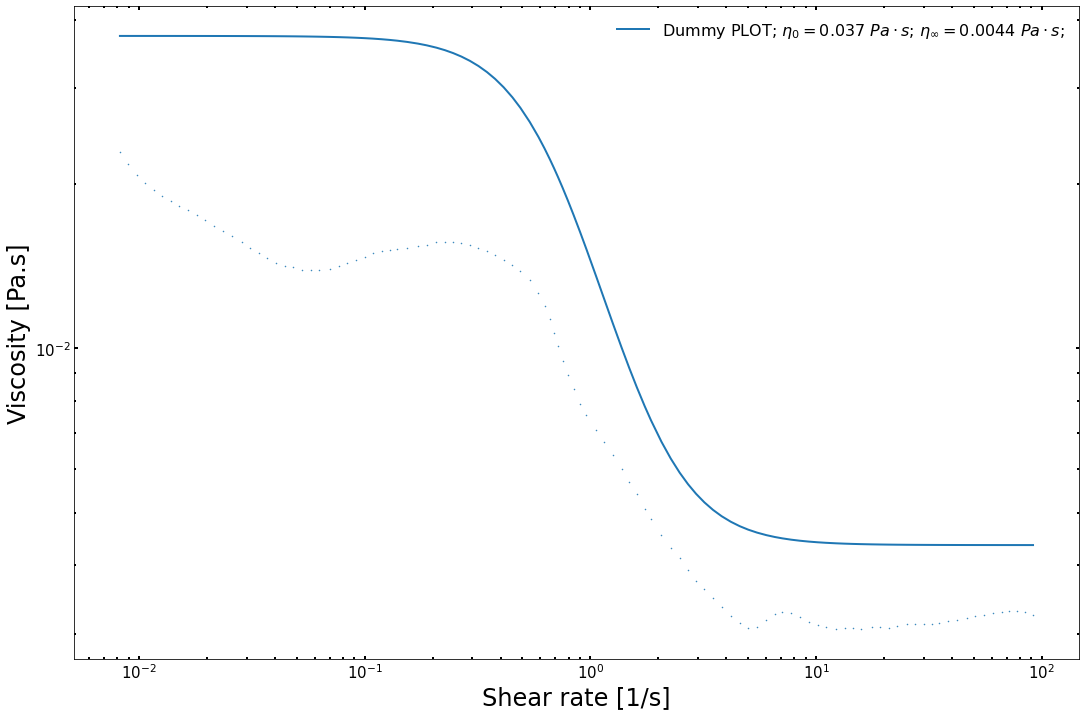

In [11]:
# TESTING FUNCTIONS
plotName        = "Dummy PLOT";
fileNames       = ["./csv/psb_nmp_00_10.csv"];
Model           = [          'CarreauYasuda'];
eta_zero        = [                0.0373544];
eta_inft        = [               0.00435907];
kappa           = [                  1.35666];
n               = [                 -1.45866];
m               = [                  2.30305];
fileDescription = [             "Dummy PLOT"];
headDrops       = [                        1];
tailDrops       = [                        0];

# Plot all files in one plot
compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m, plotDatapoints=True)

---
---
# PEO in SU8

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

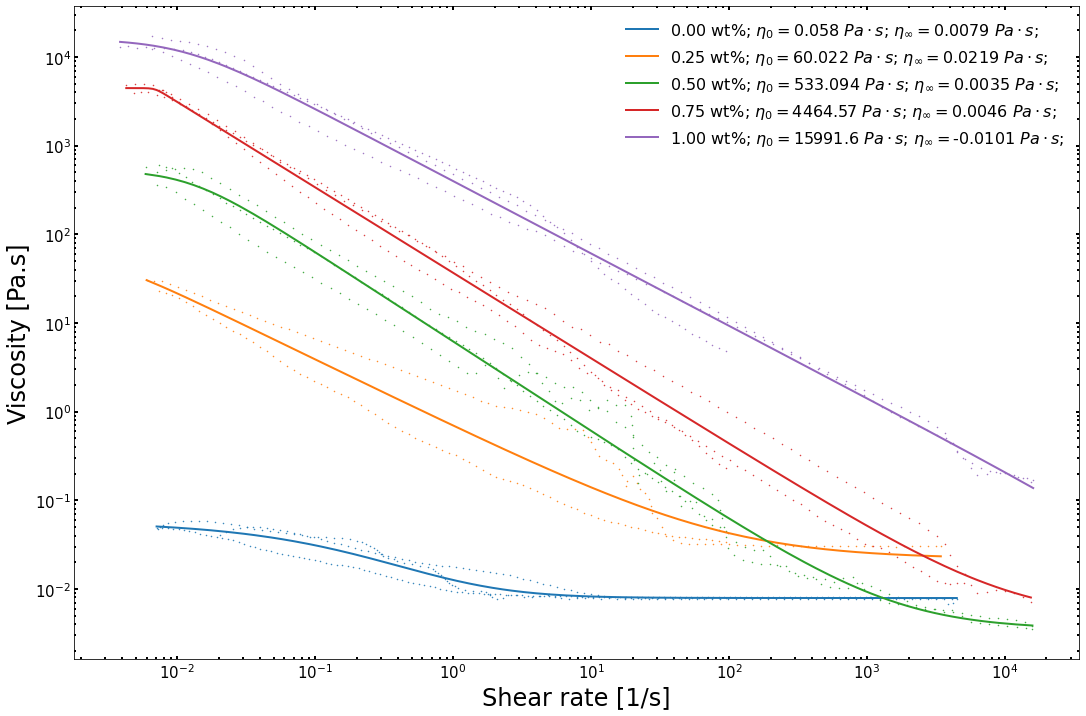

In [12]:
plotName        = "PEO wt% in SU8";
fileNames       = ["./csv/peo_su8_all_000.csv", "./csv/peo_su8_all_025.csv", "./csv/peo_su8_all_050.csv", "./csv/peo_su8_all_075.csv", "./csv/peo_su8_all_100.csv"];
Model           = [            'CarreauYasuda',                   'Carreau',                   'Carreau',             'CarreauYasuda',             'CarreauYasuda'];
eta_zero        = [                  0.0576792,                     60.0215,                     533.094,                     4464.57,                     15991.6];
eta_inft        = [                 0.00788352,                   0.0218821,                  0.00350675,                  0.00464033,                  -0.0100825];
kappa           = [                    2.59078,                     373.190,                     82.3492,                     144.815,                     91.8066];
n               = [                  -0.474137,                    0.242361,                  -0.0105593,                   0.0353161,                    0.183502];
m               = [                   0.660423,                        None,                        None,                     19.2880,                     1.70415];
fileDescription = [                 "0.00 wt%",                  "0.25 wt%",                  "0.50 wt%",                  "0.75 wt%",                  "1.00 wt%"];
headDrops       = [                          0,                           0,                           0,                           0,                           0];
tailDrops       = [                          0,                           0,                           0,                           0,                           0];

# Plot all files in one plot
compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m);

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

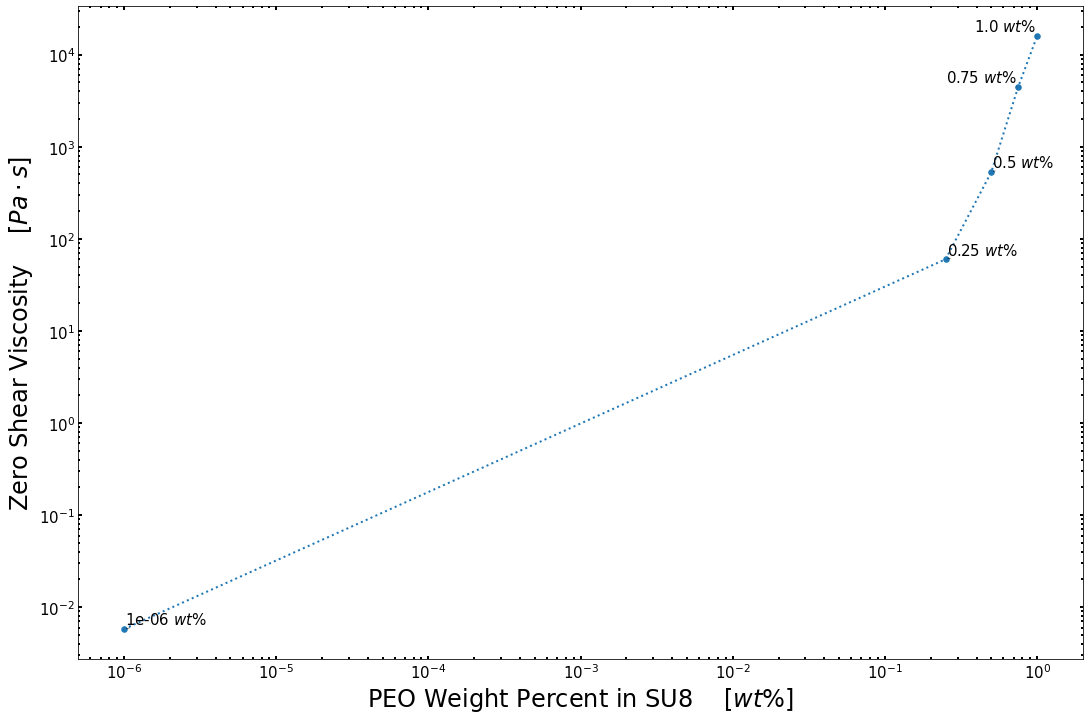

In [13]:
polymer = 'PEO';
solvent = 'SU8';
concentration = [0.000001, 0.25, 0.50, 0.75, 1.00];
viscosity     = [0.0058, 60.022, 533.094, 4464.57, 15991.6];
plot_concentrationVSviscosity(concentration, viscosity, polymer, solvent);

---
# PS in THF

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

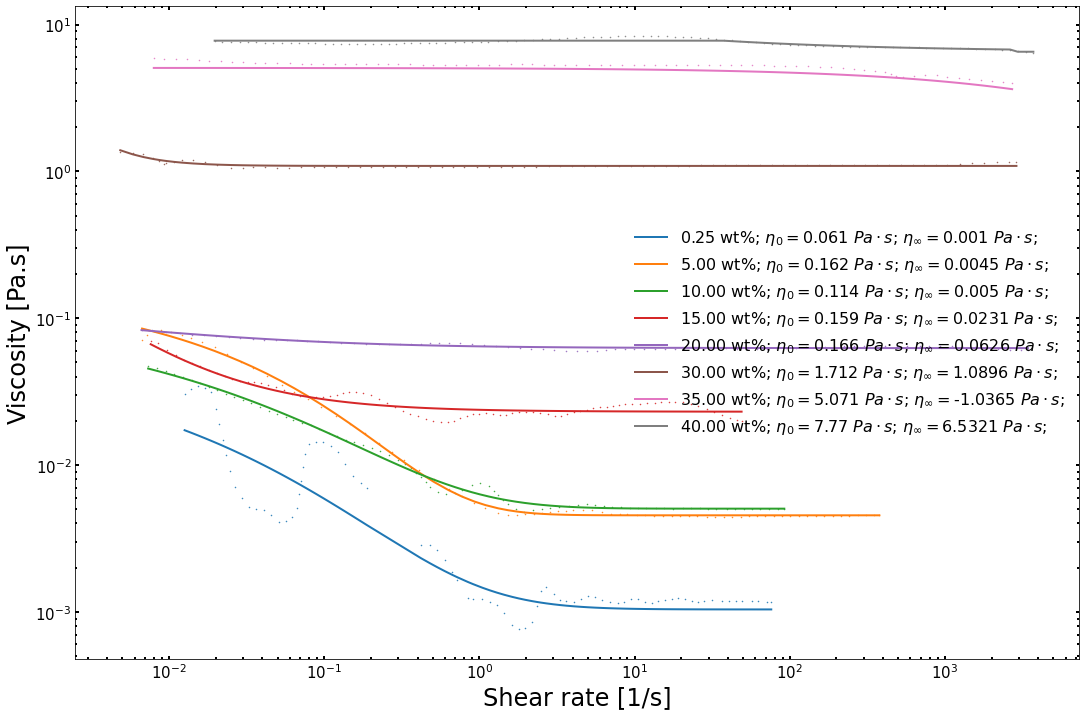

In [14]:
plotName        = "PS wt% in THF";
fileNames       = ["./csv/ps_thf_00_0.csv", "./csv/ps_thf_00_3.csv", "./csv/ps_thf_00_1.csv", "./csv/ps_thf_00_2.csv",  "./csv/ps_thf_01_2.csv", "./csv/ps_thf_01_0.csv", "./csv/ps_thf_01_3.csv", "./csv/ps_thf_01_4.csv"];
Model           = [        'CarreauYasuda',         'CarreauYasuda',         'CarreauYasuda',         'CarreauYasuda',          'CarreauYasuda',         'CarreauYasuda',         'CarreauYasuda',         'CarreauYasuda'];
eta_zero        = [              0.0613315,                0.161946,                0.113707,                 0.15866,                 0.165994,                 1.71166,                 5.07105,                 7.76980];
eta_inft        = [             0.00103819,              0.00454392,              0.00504335,               0.0230678,                0.0625735,                 1.08963,                -1.03653,                 6.53211];
kappa           = [               0.282181,              0.00833135,            0.0000977427,                 505.638,                  96.4016,                 306.032,            0.0000552504,               0.0267296];
n               = [               -2.39641,                -15.7211,                -23.7030,                  0.1556,                 0.234425,               -0.815241,                0.609282,                0.606457];
m               = [               0.345190,                0.416830,                0.309748,                 12.1529,                 0.296547,                 59.9135,                0.486477,                 162.601];
fileDescription = [             "0.25 wt%",              "5.00 wt%",             "10.00 wt%",             "15.00 wt%",              "20.00 wt%",             "30.00 wt%",             "35.00 wt%",             "40.00 wt%"];
headDrops       = [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0];
tailDrops       = [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0];
a               = [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0];

# Plot all files in one plot
compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m)

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

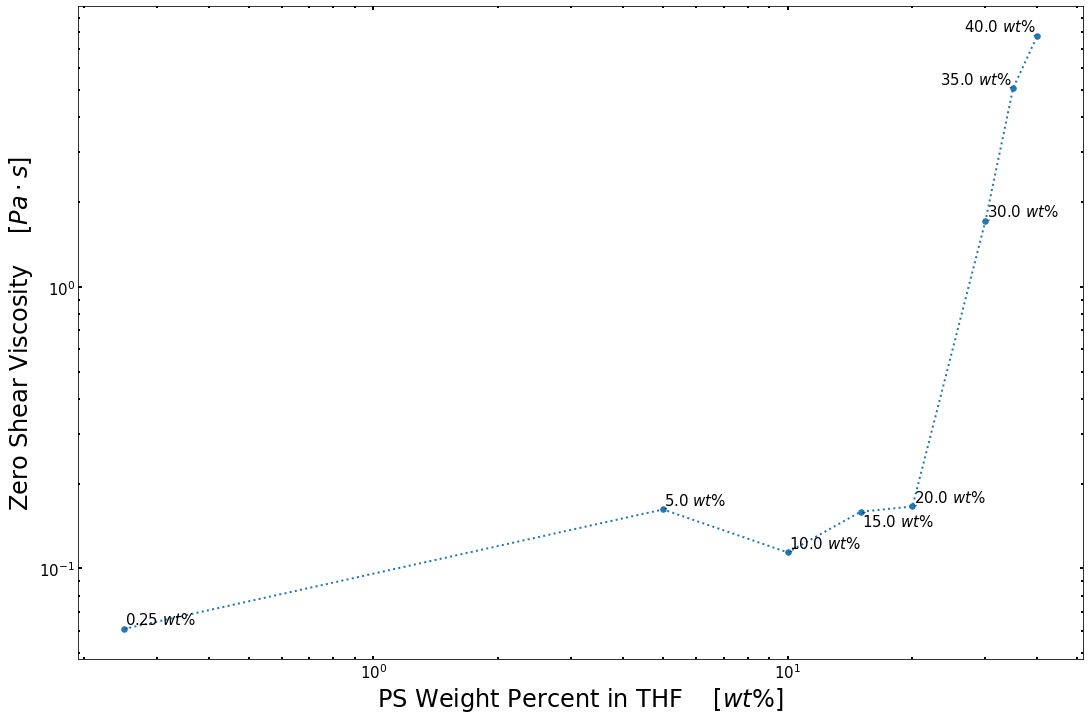

In [15]:
polymer = 'PS';
solvent = 'THF';
concentration = [ 0.25,  5.00, 10.00, 15.00, 20.00, 30.00, 35.00, 40.00];
viscosity     = [0.061, 0.162, 0.114, 0.159, 0.166, 1.712, 5.071,  7.77];
plot_concentrationVSviscosity(concentration, viscosity, polymer, solvent);

---
# PSB in NMP

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

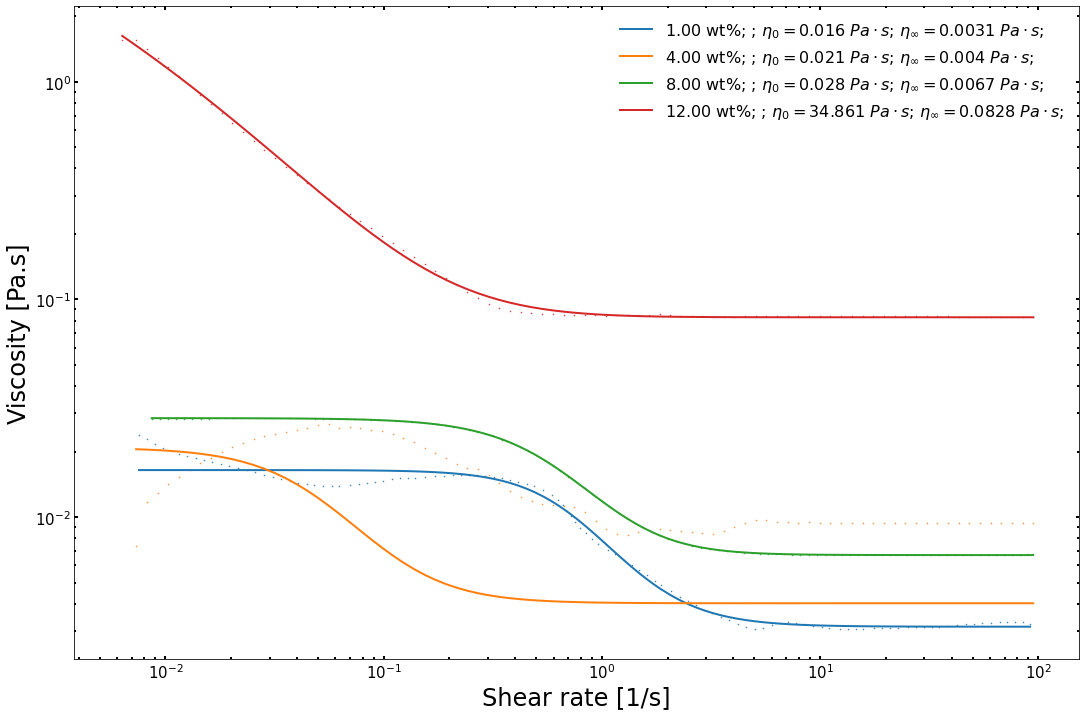

In [16]:
plotName        = "PSB wt% in NMP";
fileNames       = ["./csv/psb_nmp_00_10.csv", "./csv/psb_nmp_00_11.csv", "./csv/psb_nmp_00_12.csv", "./csv/psb_nmp_00_13.csv"];
Model           = [          'CarreauYasuda',           'CarreauYasuda',           'CarreauYasuda',           'CarreauYasuda'];
eta_zero        = [                0.0164359,                 0.0208578,                 0.0284758,                   34.8609];
eta_inft        = [               0.00313402,                0.00401552,                0.00668681,                 0.0827903];
kappa           = [                  1.36688,                   19.4089,                   1.43817,                 0.0277821];
n               = [                 -1.21730,                  -1.15933,                  -1.53303,                  -5.86097];
m               = [                  2.41365,                   2.00232,                   1.93921,                  0.246714];
fileDescription = [             "1.00 wt%; ",              "4.00 wt%; ",              "8.00 wt%; ",             "12.00 wt%; "];
headDrops       = [ 0, 0, 0, 0, 0];
tailDrops       = [ 0, 0, 0, 0, 0];
a               = [ 0, 0, 0, 0, 0];

# Plot all files in one plot
compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m)

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

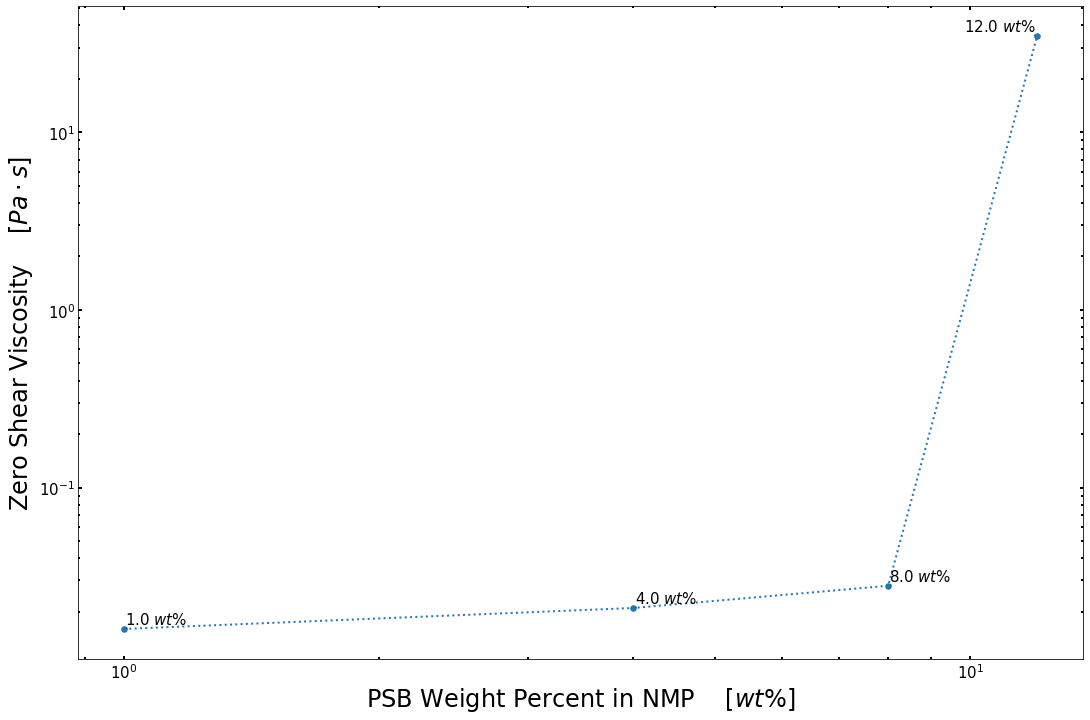

In [17]:
polymer = 'PSB';
solvent = 'NMP';
concentration = [ 1.00,  4.00,  8.00, 12.00];
viscosity     = [0.016, 0.021, 0.028, 34.861];
plot_concentrationVSviscosity(concentration, viscosity, polymer, solvent);

---
# PSB in THF and DMF

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

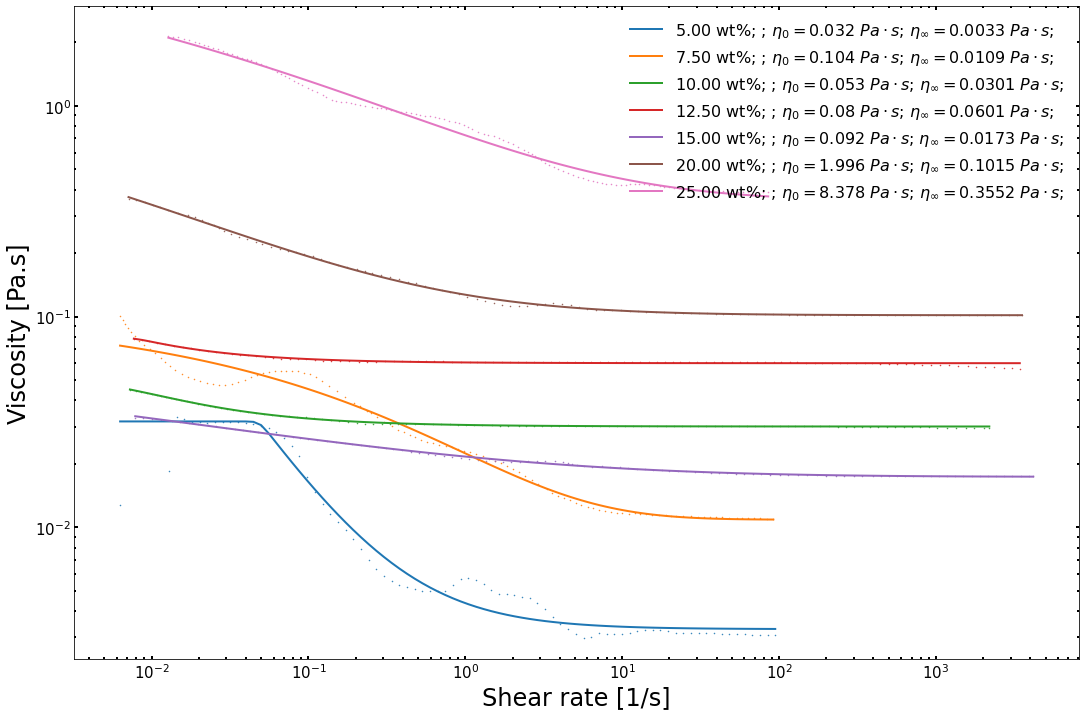

In [18]:
plotName        = "PSB wt% in THF and DMF";
fileNames       = [ "./csv/PSB_THFDMF_00_6.csv", "./csv/PSB_THFDMF_00_7.csv", "./csv/PSB_THFDMF_01_7.csv", "./csv/PSB_THFDMF_01_8.csv", "./csv/PSB_THFDMF_01_5.csv", "./csv/PSB_THFDMF_01_6.csv", "./csv/PSB_THFDMF_00_5.csv"];
Model           = [             'CarreauYasuda',             'CarreauYasuda',             'CarreauYasuda',             'CarreauYasuda',             'CarreauYasuda',             'CarreauYasuda',             'CarreauYasuda'];
eta_zero        = [                   0.0317899,                    0.104231,                   0.0529622,                   0.0796603,                   0.0924487,                     1.99619,                     8.37823];
eta_inft        = [                  0.00328526,                   0.0108672,                   0.0300774,                   0.0600711,                   0.0173480,                    0.101458,                    0.355241];
kappa           = [                     20.4763,               0.00000345047,                     185.285,                     131.274,                0.0000370328,                    0.659296,              0.000000148113];
n               = [                  -0.0836830,                    -38.1028,                    0.272104,                    0.238467,                   -0.859592,                   -0.309737,                    -6.14613];
m               = [                     23.7864,                    0.322261,                     1.67858,                     9.60607,                    0.139896,                    0.198368,                    0.165613];
fileDescription = [                "5.00 wt%; ",                "7.50 wt%; ",               "10.00 wt%; ",               "12.50 wt%; ",               "15.00 wt%; ",               "20.00 wt%; ",               "25.00 wt%; "];
headDrops       = [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ];
tailDrops       = [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ];
a               = [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ];

# Plot all files in one plot
compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m)

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

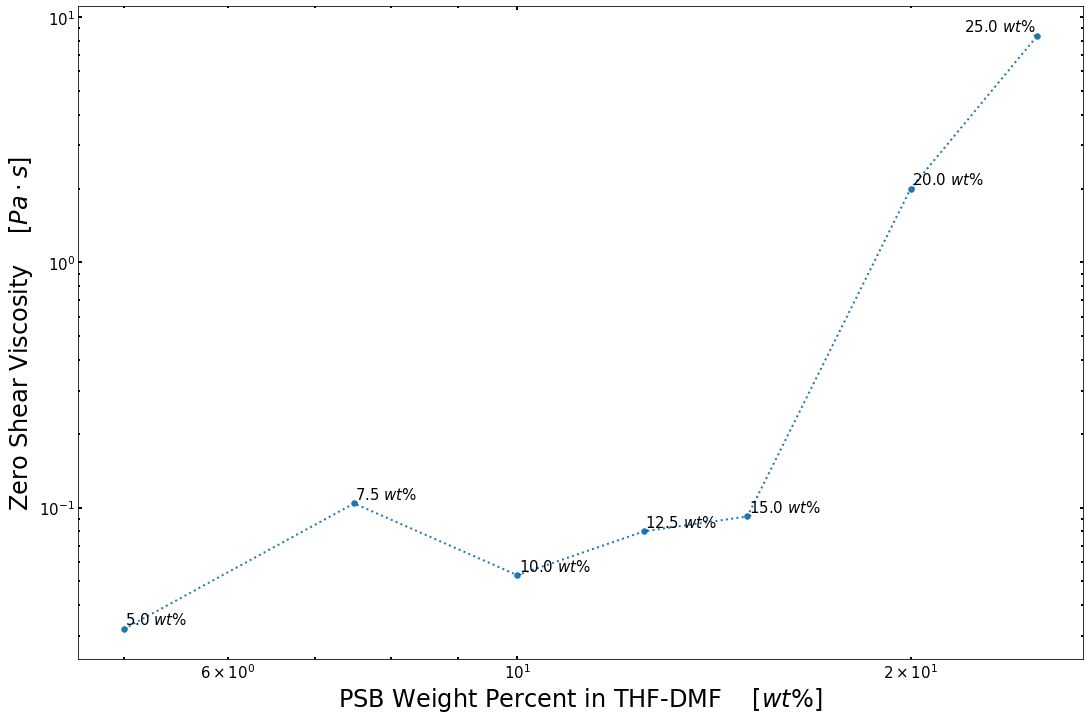

In [19]:
polymer = 'PSB';
solvent = 'THF-DMF';
concentration = [5.00,   7.50, 10.00, 12.50, 15.00, 20.00, 25.00];
viscosity     = [0.032, 0.104, 0.053,  0.08, 0.092, 1.996, 8.378];
plot_concentrationVSviscosity(concentration, viscosity, polymer, solvent);

---
# PSMS in DMF

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

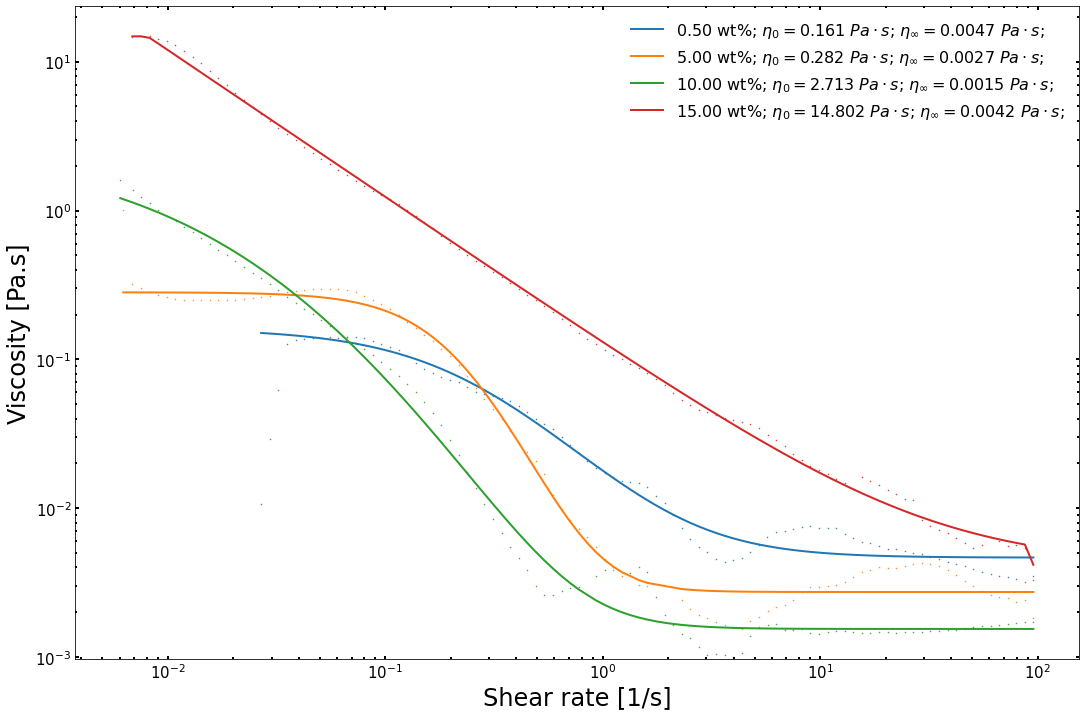

In [30]:
plotName        = "PSMS wt% in DMF";
fileNames       = ["./csv/psms_dmf_00_6.csv", "./csv/psms_dmf_00_7.csv", "./csv/psms_dmf_00_8.csv", "./csv/psms_dmf_00_10.csv"];
Model           = [          'CarreauYasuda',           'CarreauYasuda',           'CarreauYasuda',            'CarreauYasuda'];
eta_zero        = [                 0.161264,                  0.282163,                   2.71305,                    14.8015];
eta_inft        = [               0.00465213,                0.00273374,                0.00154317,                 0.00416426];
kappa           = [                  3.97780,                   4.50601,                   19.2024,                    123.939];
n               = [                -0.641457,                  -2.27904,                  -1.61674,                  0.0124974];
m               = [                  1.27503,                   2.03869,                  0.677510,                    76.4016];
fileDescription = [               "0.50 wt%",                "5.00 wt%",               "10.00 wt%",                "15.00 wt%"];
headDrops       = [ 0, 0, 0, 0 ];
tailDrops       = [ 0, 0, 0, 0 ];

# Plot all files in one plot
compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m)

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

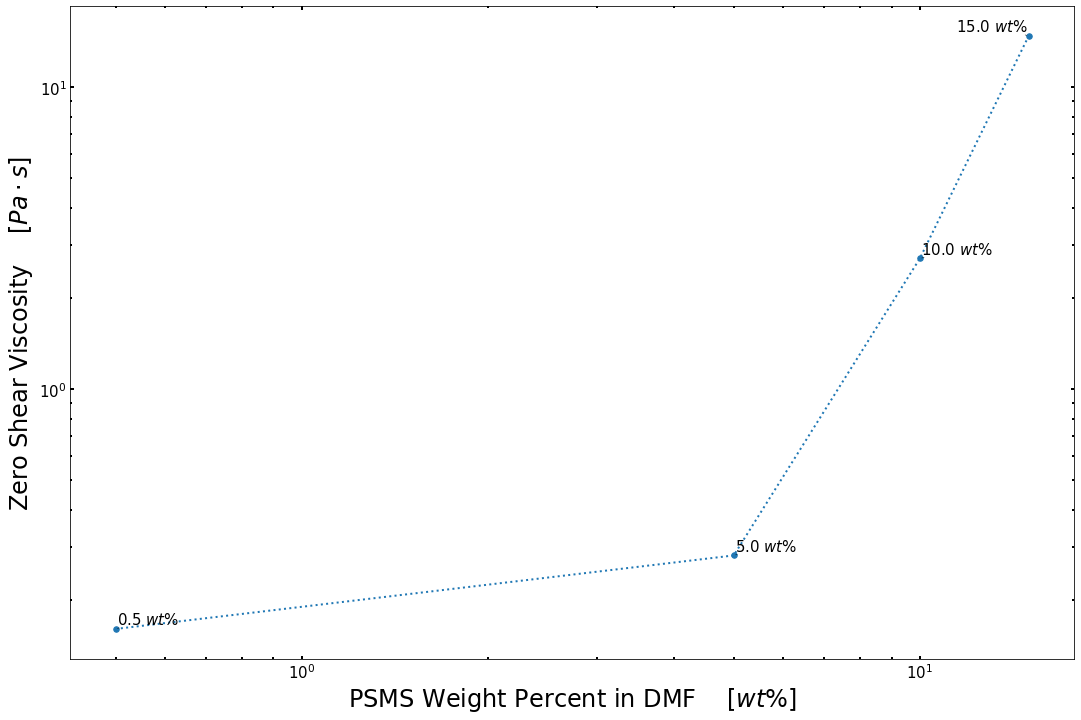

In [21]:
polymer = 'PSMS';
solvent = 'DMF';
concentration = [ 0.50,  5.00, 10.00,  15.00];
viscosity     = [0.161, 0.282, 2.713, 14.802];
plot_concentrationVSviscosity(concentration, viscosity, polymer, solvent);

---
# PVK in CHL

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

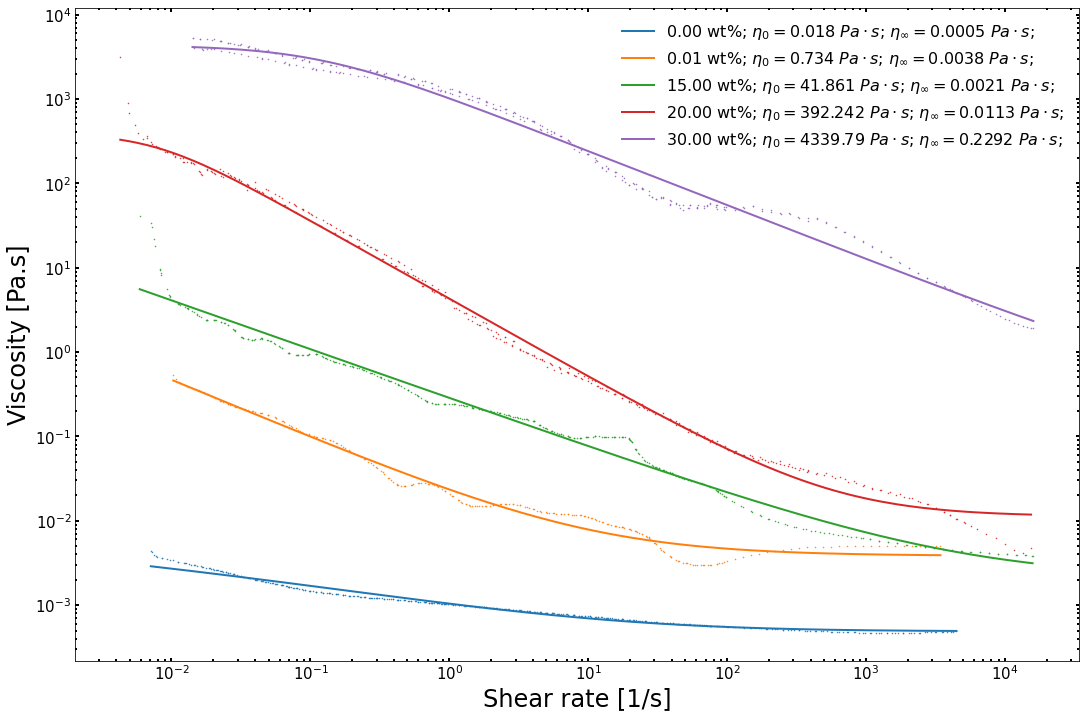

In [22]:
plotName        = "PVK wt% in CHL";
fileNames       = ["./csv/pvk_chl_00_0.csv", "./csv/pvk_chl_00_1.csv", "./csv/pvk_chl_00_2.csv", "./csv/pvk_chl_00_3.csv", "./csv/pvk_chl_00_4.csv"];
Model           = [         'CarreauYasuda',          'CarreauYasuda',          'CarreauYasuda',          'CarreauYasuda',          'CarreauYasuda'];
eta_zero        = [               0.0178832,                 0.733928,                  41.8606,                  392.242,                  4339.79];
eta_inft        = [              0.00048989,               0.0038327,                0.00208968,                0.0112680,               0.229249];
kappa           = [          0.000000741759,                  192.732,                  5525.44,                  130.915,                  8.95728];
n               = [                -1.43367,                0.312959,                  0.420499,                0.0729450,                0.357149];
m               = [                0.119611,                  20.8330,                  4.06853,                  1.67450,                  1.12951];
fileDescription = [              "0.00 wt%",               "0.01 wt%",              "15.00 wt%",              "20.00 wt%",              "30.00 wt%"];
headDrops       = [ 0, 0, 0, 0, 0 ];
tailDrops       = [ 0, 0, 0, 0, 0 ];

# Plot all files in one plot
compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m)

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

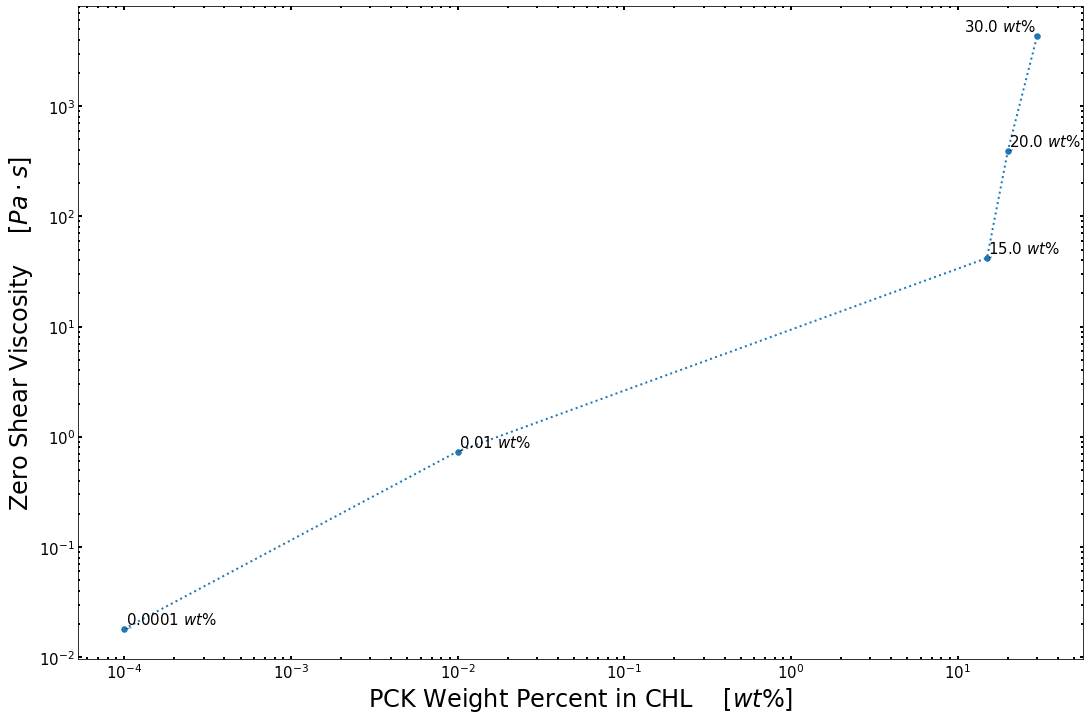

In [23]:
polymer = 'PCK';
solvent = 'CHL';
concentration = [0.0001,  0.01, 15.00,   20.00,     30.0];
viscosity     = [ 0.018, 0.734, 41.861, 392.242, 4339.79];
plot_concentrationVSviscosity(concentration, viscosity, polymer, solvent);

---
# PVK in SU-8

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

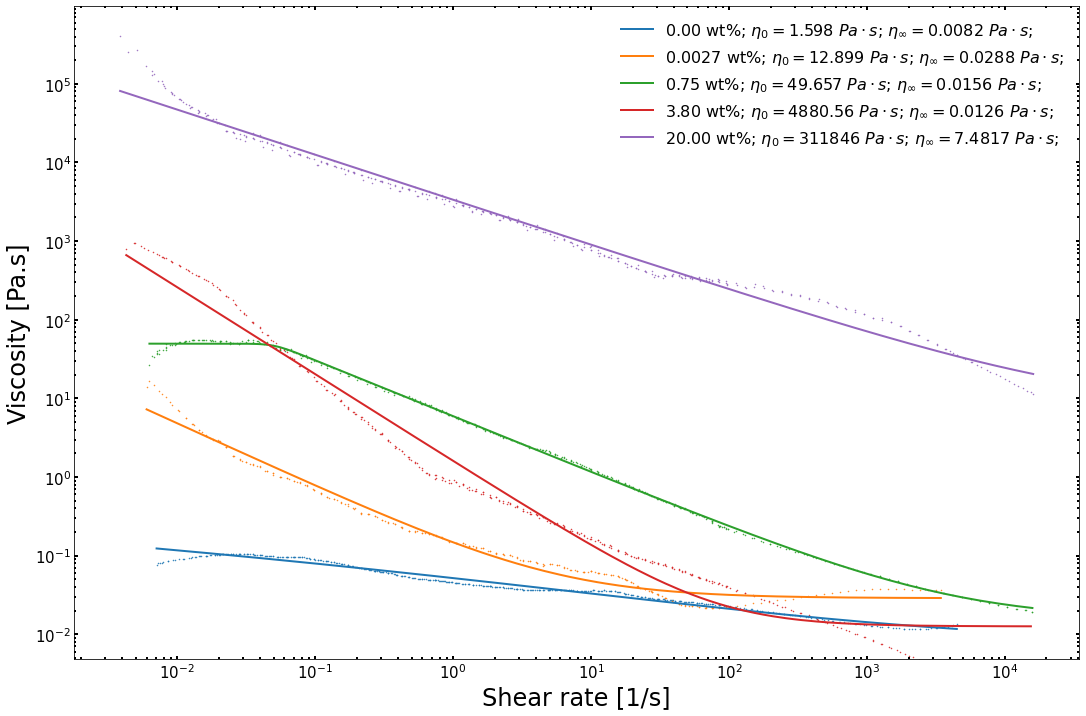

In [24]:
plotName        = "PVK wt% in SU8";
fileNames       = ["./csv/pvk_su8_00_0.csv", "./csv/pvk_su8_00_1.csv", "./csv/pvk_su8_00_2.csv", "./csv/pvk_su8_00_3.csv", "./csv/pvk_su8_00_4.csv"];
Model           = [         'CarreauYasuda',          'CarreauYasuda',          'CarreauYasuda',          'CarreauYasuda',          'CarreauYasuda'];
eta_zero        = [                 1.59849,                 12.8994,                  49.6569,                   4880.56,                  311846];
eta_inft        = [              0.00823985,               0.0287641,                0.0155515,                  0.012598,               7.48169];
kappa           = [             6.05562e-33,                  341.820,                  19.7619,                  1420.02,                  2701.12];
n               = [                -25.3092,                0.197417,                  0.287743,                -0.105834,                0.426224];
m               = [               0.0638541,                  27.0890,                  7.67389,                  6.73073,                6.38515];
fileDescription = [              "0.00 wt%",               "0.0027 wt%",              "0.75 wt%",              "3.80 wt%",              "20.00 wt%"];
headDrops       = [ 0, 0, 0, 0, 0 ];
tailDrops       = [ 0, 0, 0, 0, 0 ];

# Plot all files in one plot
compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m)

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

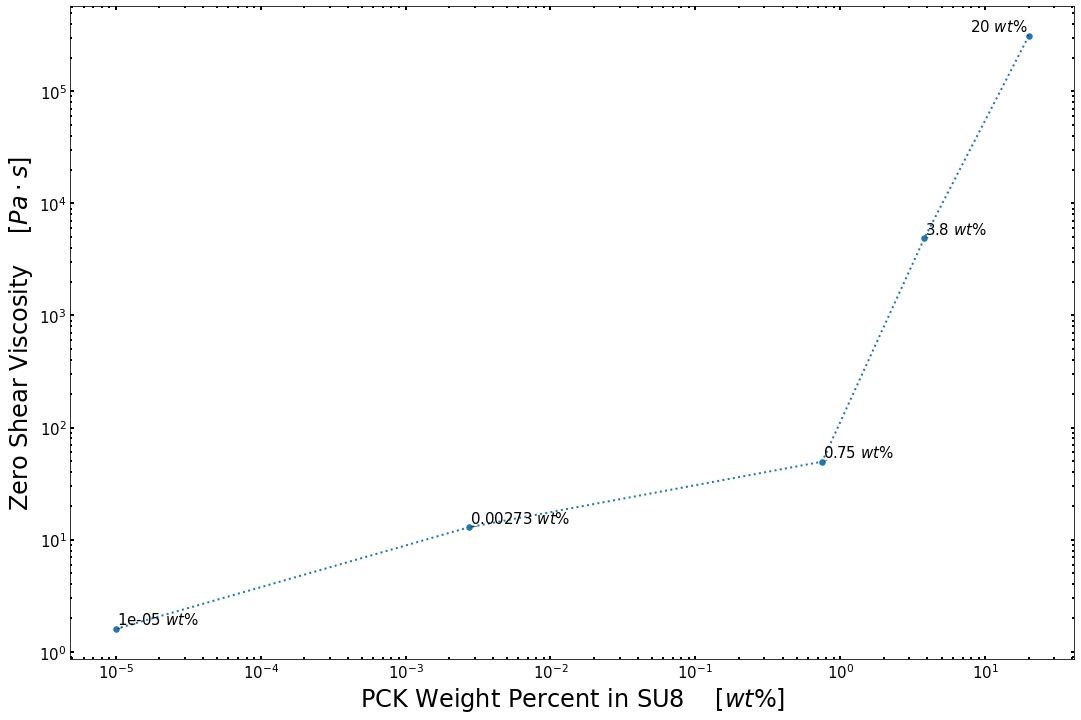

In [25]:
polymer = 'PCK';
solvent = 'SU8';
concentration = [0.00001, 0.00273,   0.75,     3.8,     20];
viscosity     = [  1.598,  12.899, 49.657, 4880.56, 311846];
plot_concentrationVSviscosity(concentration, viscosity, polymer, solvent);

---
---
---

---
# SU-8 2002 viscosity

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

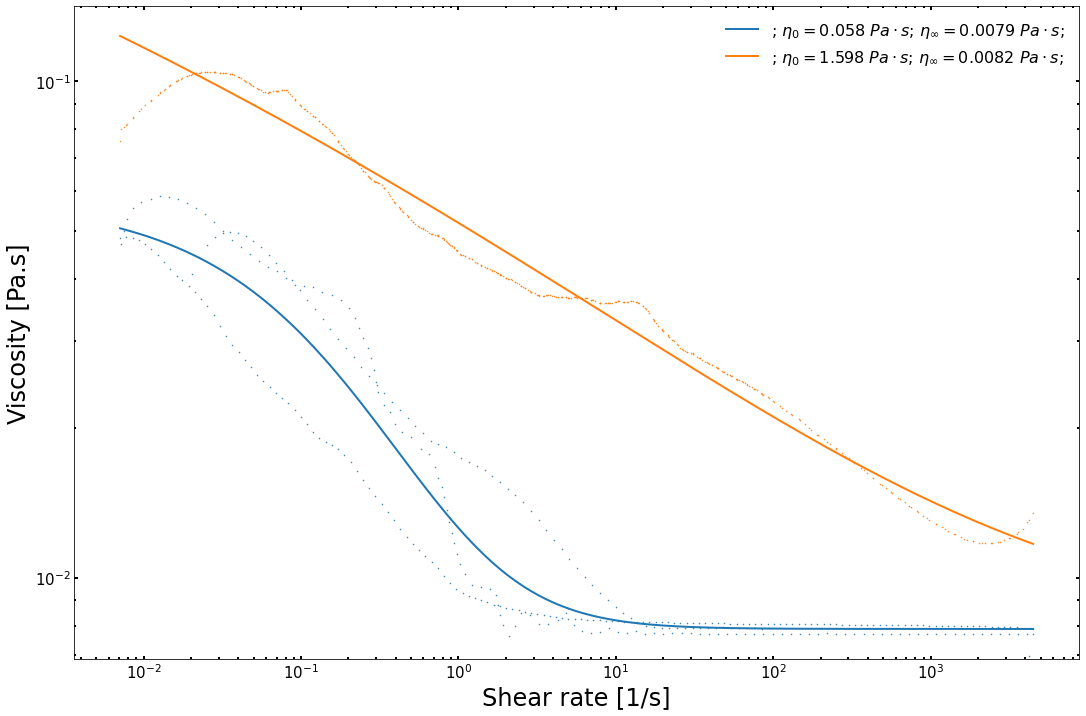

In [26]:
plotName        = "SU-8 2002 viscosity";
fileNames       = ["./csv/peo_su8_all_000.csv", "./csv/pvk_su8_00_0.csv"];
Model           = [            'CarreauYasuda',          'CarreauYasuda'];
eta_zero        = [                  0.0576792,                  1.59849];
eta_inft        = [                 0.00788352,               0.00823985];
kappa           = [                    2.59078,              6.05562e-33];
n               = [                  -0.474137,                 -25.3092];
m               = [                   0.660423,                0.0638541];
fileDescription = [                         "",                       ""];
headDrops       = [ 0, 0 ];
tailDrops       = [ 0, 0 ];
                   
# Plot all files in one plot
compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m);

---
# CHL viscosity

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

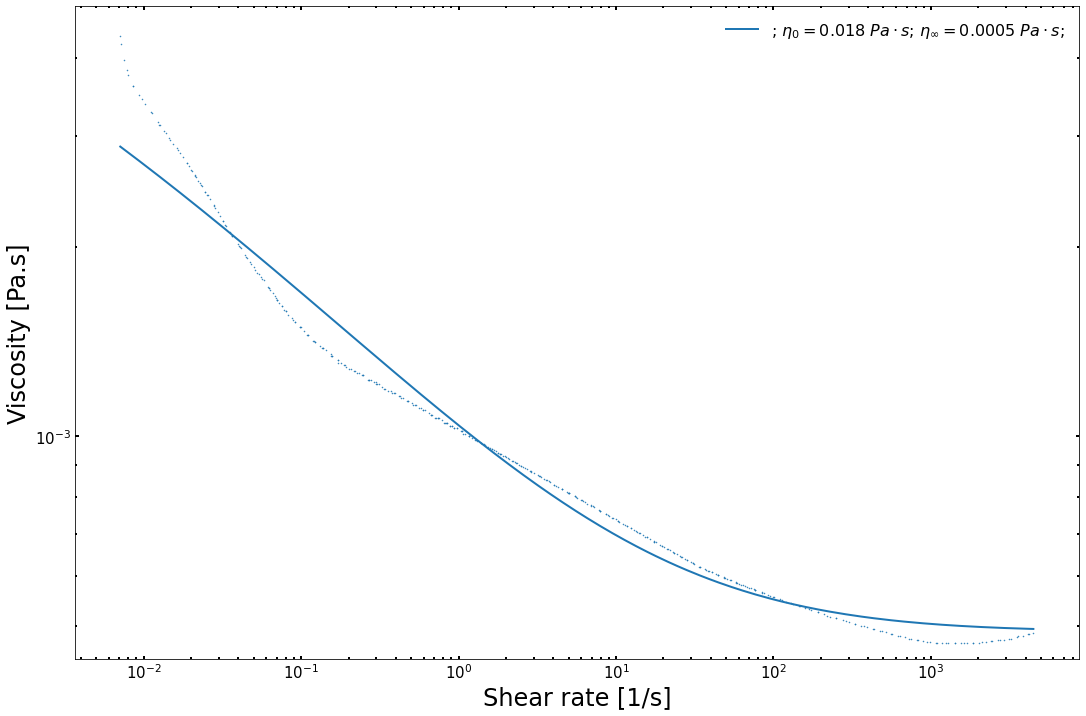

In [27]:
plotName        = "CHL viscosity";
fileNames       = ["./csv/pvk_chl_00_0.csv"];
Model           = [         'CarreauYasuda'];
eta_zero        = [               0.0178832];
eta_inft        = [              0.00048989];
kappa           = [          0.000000741759];
n               = [                -1.43367];
m               = [                0.119611];
fileDescription = [                      ""];
headDrops       = [ 0 ];
tailDrops       = [ 0 ];
                   
# Plot all files in one plot
compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m);

---
# Standard Conforming to ASTM Oil Standard

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

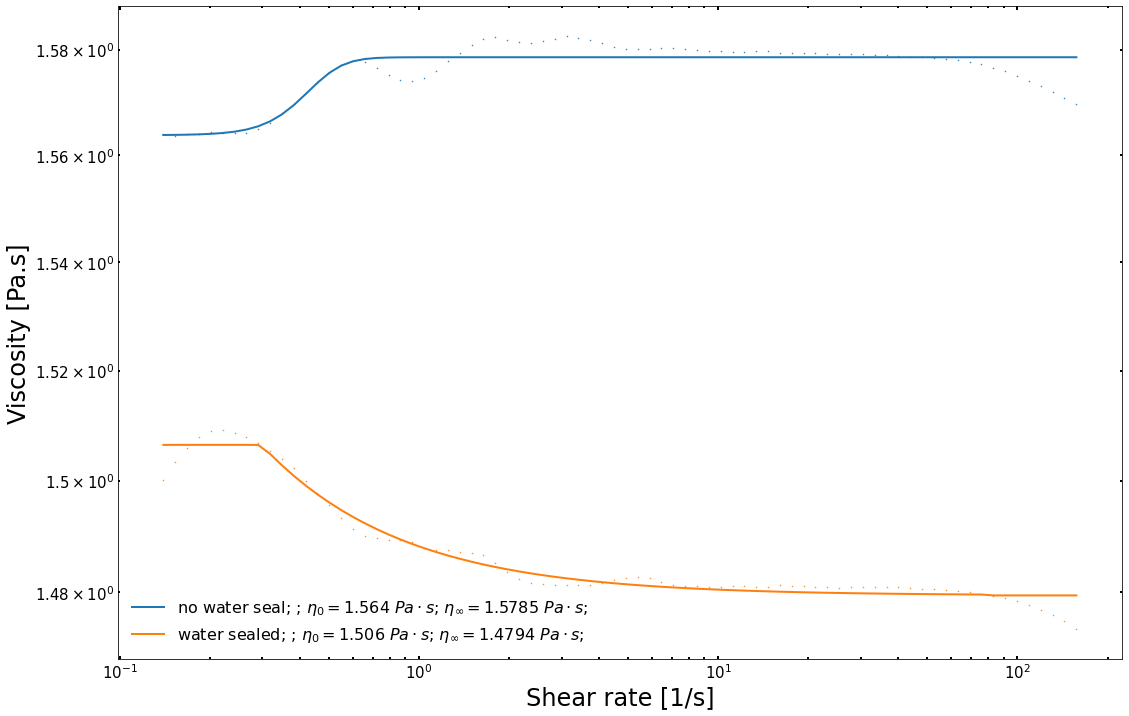

In [28]:
plotName        = "Standard Conforming to ASTM Oil Standard - Water Seal Test";
fileNames       = ["./csv/std_noseal.csv", "./csv/std_sealed.csv"];
Model           = [       'CarreauYasuda',        'CarreauYasuda'];
eta_zero        = [               1.56377,                1.50646];
eta_inft        = [               1.57853,                1.47937];
kappa           = [               2.03980,                3.36134];
n               = [              -10.4543,              0.0696546];
m               = [               5.41514,                128.111];
fileDescription = [     "no water seal; ",       "water sealed; "];
headDrops       = [                    34,                     34];
tailDrops       = [                    51,                     51];

# Plot all files in one plot
compareData_wFits_(plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m)

---
---
---

In [29]:
print(np.logspace(np.log10(0.00001), np.log10(0.25), 5)) #3.75

[1.00000000e-05 1.25743343e-04 1.58113883e-03 1.98817682e-02
 2.50000000e-01]


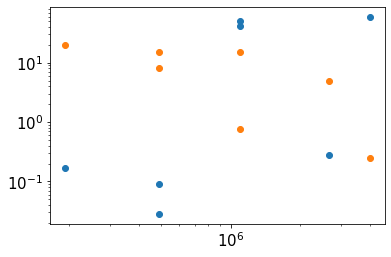

In [38]:
plt.scatter(
    [192000, 490000, 490000, 1100000, 1100000, 2658076, 4000000],
    [ 0.166,  0.028,  0.092,  41.861,  49.657,   0.282,  60.022]
)

plt.scatter(
    [192000, 490000, 490000, 1100000, 1100000, 2658076, 4000000],
    [ 20.00,   8.00,  15.00,   15.00,    0.75,    5.00,    0.25]
)
plt.xscale('log');
plt.yscale('log');